# Training a Siamese Network on the CICY3 dataset

This notebook describes how a Siamese Network is trained to learn similarity across the CICY3 dataset.

The criterion for similarity that we are using is that two CICY3 manifolds $x_I$ and $x_J$ are similar to each other if they share the same value of the Hodge number $h^{1,1}$, i.e.
\begin{equation}
x_I \sim x_J \quad \iff \quad h_I^{1,1} = h_J^{1,1}\,.
\end{equation}
Given this criterion, the Siamese Network learns an embedding of the input data into an auxiliary space ($\mathbb{R}^3$ here) such that similar points are clustered together.

We train the model and visualize the learnt similarity score. The representation of the input data learnt by the features network is subsequently used in later notebooks to infer the value of $h^{1,1}$ for training set matrices.

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

#from keras.layers.merge import concatenate
#from keras.layers import add,Activation
from tensorflow.keras.models import load_model

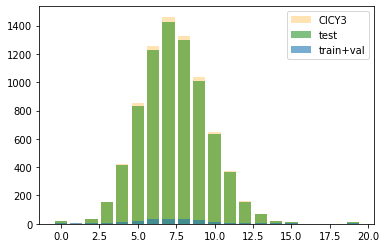

+-----+--------------------+-------------------+--------------+----------------+
|   h |   train population |   test population |   train+test |   h population |
+=====+====================+===================+==============+================+
|   0 |                  3 |                19 |           22 |             22 |
+-----+--------------------+-------------------+--------------+----------------+
|   1 |                  3 |                 2 |            5 |              5 |
+-----+--------------------+-------------------+--------------+----------------+
|   2 |                  3 |                33 |           36 |             36 |
+-----+--------------------+-------------------+--------------+----------------+
|   3 |                  3 |               152 |          155 |            155 |
+-----+--------------------+-------------------+--------------+----------------+
|   4 |                 10 |               415 |          425 |            425 |
+-----+--------------------+

In [3]:
data_loc= '/kaggle/input/cicy-3-fold-dataset/'

df_cicy=pd.read_hdf(data_loc+'cicy3f.h5')

h='h11'

min_sample, ratio = 3,0.025
traintest = StratifiedSampler(df_cicy,h,min_sample,ratio)
x_train, x_test = traintest.stratified_split(['matrix'])
traintest.plot_population()
traintest.pretty_print()
x_train, x_test, y_train, y_test = x_train['matrix'], x_test['matrix'], x_train[h], x_test[h]

In [4]:
upsampled_h, upsampled_w = 18,18
pad_type = 'constant'
ravel = False
cicypad = CicyPad(upsampled_h,upsampled_w,pad_type,ravel)
x_train, x_test = cicypad.fit_transform(x_train), cicypad.fit_transform(x_test)

X_train, Y_train = x_train,y_train

In [5]:
x_train.shape

(210, 18, 18)

In [6]:
def populations(x,y,dataset):
    h = np.unique(y)
    print('class populations in the ', dataset, 'set')
    for i in h:
        print(int(i),len(x[np.where(y==i)[0]]))

In [7]:
test_size = 0.1
x_16 = x_train[np.where(y_train==16)[0]]
x_train = x_train[np.where(y_train!=16)[0]]
y_train = y_train[np.where(y_train!=16)[0]]
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=test_size,random_state = 1,stratify=y_train)
x_train = np.vstack([x_train,x_16])
y_train = np.hstack([y_train,[16]])
print(x_train.shape,x_val.shape)

(189, 18, 18) (21, 18, 18)


In [8]:
x_train,y_train = upsample(x_train,y_train,80)
x_val,y_val = upsample(x_val,y_val,80)
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)

(1440, 18, 18) (1440,)
(720, 18, 18) (720,)


In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(1024).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.shuffle(1024).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.shuffle(1024).batch(32)

# The Features Network

The input data consists of CICY3 configuration matrices, which are 2d tensors. Hence, they can naturally be interpreted as grayscale images. The row and column locations give the location of the pixel while the matrix entry is the pixel intensity.

For this reason, the features network used to process these matrices is chosen to be a convolutional neural network. As a preprocessing step, the input image is rescaled so that its pixel values lie between 0 and 1 and have a standard deviation of 1.

In [10]:
kernel_regularizer = None

reg=None #keras.regularizers.l1_l2(1e-4,1e-4)

def build_siamese_model(inputShape, embeddingDim=3):
    # specify the inputs for the feature extractor network
    inputs = Input(inputShape)
    x = tf.image.per_image_standardization(inputs)
    # define the first set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(32, (3, 3), padding="same", activation="relu",
               kernel_regularizer=kernel_regularizer)(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)
    # second set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(256, (3, 3), padding="same", activation="relu",
               kernel_regularizer=None)(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    # prepare the final outputs
    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)
    outputs = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(outputs)
    # build the model
    model = Model(inputs, outputs)
    # return the model to the calling function
    return model

# Training the Siamese Network

We train the network using the _Triplet loss function_ focusing on semi-hard triplets in each epoch. This loss function is defined by considering a triplet $(x_a,x_p,x_n)$ of input data where $x_a$ is an _anchor_ or reference image, $x_p$ is a _positive_ image, i.e. $x_a$ and $x_p$ are similar, and $x_n$ is a negative image, i.e. $x_a$ and $x_n$ are not similar.

The loss function is defined by
\begin{equation}
\mathcal{L} = \sum_{(x_a,x_p,x_n)} \max\left(d(x_a,x_p)-d(x_a,x_n)+\alpha,0\right\rbrace\,,
\end{equation}
where $\alpha$ is a hyperparameter called the _margin_. Here $d\left(x_1,x_2\right)$ is the distance between two data when represented in embedding space. To unpack this, let $\phi$ be the embedding function learnt by the features network. Then $\phi(x)$ is a vector in $\mathbb{R}^3$ with components $\phi_1(x),\phi_2(x), \phi_3(x)$ and the distance $d(x_1,x_2)$ is given by

\begin{equation}
d\left(x_1,x_2\right) = \left(\phi_1(x_1)-\phi_1(x_2)\right)^2 + \left(\phi_2(x_1)-\phi_2(x_2)\right)^2 + \left(\phi_3(x_1)-\phi_3(x_2)\right)^2 \equiv \vert \phi(x_1)-\phi(x_2)\vert^2\,.
\end{equation}

The contribution of a particular triplet $(x_a,x_p,x_n)$ to the loss function is zero (the minimum) when $d(x_a,x_p) +1 < d(x_a,x_n)$. Hence this loss function incentivizes the Siamese Network to learn an embedding $\phi$ under which similar points are clustered together while dissimilar points are pushed far apart.

We use the _TripletSemiHardLoss_ function of tensorflow-addons to train the Siamese Network. This choice of the loss function focuses on those triplets for which $d(x_a,x_p) +1> d(x_a,x_n)$ but $d(x_a,x_p) < d(x_a,x_n)$. In these triplets, $x_p$ is closer to the anchor than $x_n$, but they still contribute to the loss function.

We will also use callbacks _ReduceLROnPlateau_ to reduce the learning rate when the loss function plateaus as well as _ModelCheckpoint_ to save the best model (minimum validation loss) during training.

In [11]:
IMG_SHAPE =(upsampled_h,upsampled_w,1)
embeddingDim =3
features = build_siamese_model(IMG_SHAPE,embeddingDim = embeddingDim)

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,#np.sqrt(0.1),
                               cooldown=30,
                               patience= 10,
                               verbose = 1,
                               min_lr=5e-3)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint('features.h5',
                                                      monitor="val_loss",
                                                      verbose=1,
                                                      save_best_only=True,
                                                      save_weights_only=False,
                                                      mode="auto",
                                                      save_freq="epoch")

callbacks = [model_checkpoint,lr_reducer]

In [12]:
features.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-1),loss=tfa.losses.TripletSemiHardLoss(margin=1.0))
history = features.fit(train_dataset,validation_data=val_dataset,epochs=600,callbacks=callbacks)

Epoch 1/600
45/45 [==============================] - 9s 19ms/step - loss: 0.9892 - val_loss: 0.9389

Epoch 00001: val_loss improved from inf to 0.93889, saving model to features.h5
Epoch 2/600
45/45 [==============================] - 0s 6ms/step - loss: 0.9652 - val_loss: 0.8864

Epoch 00002: val_loss improved from 0.93889 to 0.88643, saving model to features.h5
Epoch 3/600
45/45 [==============================] - 0s 6ms/step - loss: 0.9202 - val_loss: 0.9478

Epoch 00003: val_loss did not improve from 0.88643
Epoch 4/600
45/45 [==============================] - 0s 6ms/step - loss: 0.9064 - val_loss: 0.9493

Epoch 00004: val_loss did not improve from 0.88643
Epoch 5/600
45/45 [==============================] - 0s 6ms/step - loss: 0.9099 - val_loss: 0.9685

Epoch 00005: val_loss did not improve from 0.88643
Epoch 6/600
45/45 [==============================] - 0s 6ms/step - loss: 0.9252 - val_loss: 0.9380

Epoch 00006: val_loss did not improve from 0.88643
Epoch 7/600
45/45 [============

Load the best model (minimum validation loss) for evaluating the test set on.

In [13]:
features = load_model('features.h5',compile=False)

In [14]:
x_embedding = features.predict(x_test)
x_embedding.shape

(7681, 3)

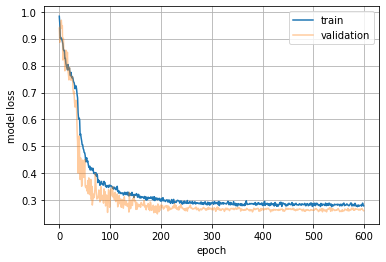

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'],alpha=0.4)
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.grid('both')
plt.show()

# Visualizing the Embedding and Similarity Scores

The Siamese Net learns a representation of the input data, the CICY3 manifolds, as points in an embedding space $\mathbb{R}^3$ where manifolds $x_I$ that share the same value $h^{1,1}_I$ of the Hodge number $h^{1,1}$ are clustered together.  We now visualize this clustering.

While a numerical evaluation of the goodness of the learnt clustering is possible, and is done separately, that requires the use of a clustering algorithm such as a K nearest neighbors classifier, or more sophisticated means. As such, this represents an added layer of complexity on top of the SNN. Prior to that, we would like some means of visualizing both the clustering and how well it carries the desired properties of the learnt similarity score. 

For starters, since the clustering is already in $\mathbb{R}^3$, we can readily visualize the learnt embedding as a scatter plot.

In [15]:
h11 = np.unique(y_test)
pop_h11 = [len(x_test[y_test==h]) for h in h11]
sizes=[100/np.log(p+1) for p in pop_h11]

scattersize = np.empty(*y_test.shape)
for i in range(len(h11)):
    scattersize[np.where(y_test==h11[i])[0]]=sizes[i]

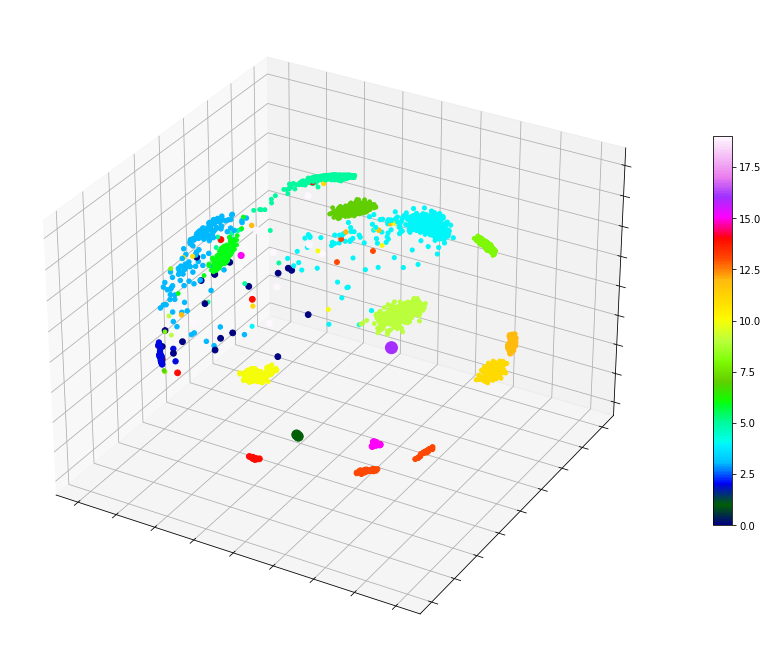

In [16]:
fig = plt.figure(figsize=(16, 9))
plt.clf()
ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)


plt.cla()

img=ax.scatter(x_embedding[:, 0], x_embedding[:, 1], x_embedding[:, 2],c=y_test,s=scattersize,alpha=1,cmap='gist_ncar')
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

for line in ax.xaxis.get_ticklines():
    line.set_visible(False)
for line in ax.yaxis.get_ticklines():
    line.set_visible(False)
for line in ax.zaxis.get_ticklines():
    line.set_visible(False)

fig.colorbar(img,shrink=0.6)

plt.show()

In [18]:
h11=np.unique(y_test)
nclass=len(h11)
print(nclass)

18


## Visualizing the Similarity Score

The Siamese Network learns an embedding $\phi$ of the input CICY3 data such that given the subsets $\lbrace x_I\rbrace$ and $\lbrace x_J\rbrace$ of CICY3 which correspond to $h^{1,1}_I$ and $h^{1,1}_J$ respectively, 
\begin{equation*}
\vert \phi(x_I)-\phi(x_J)\vert ^2 \approx 0 \quad \iff \quad I=J\,.
\end{equation*}
We can visualize this property. 

To do so, we compute the _mean similarity score_ between $\lbrace x_I\rbrace$ and $\lbrace x_J\rbrace$
\begin{equation*}
s_{IJ}=\frac{1}{N_I N_J}\sum_{\lbrace x_I\rbrace,\lbrace x_J\rbrace}\vert \phi(x_I)-\phi(x_J)\vert ^2 \,,
\end{equation*}
where $N_I$ and $N_J$ are the number of elements in classes $I$ and $J$ respectively.

The learnt similarity score should obey
\begin{equation*}
s_{IJ} \approx 0 \iff I=J \,,
\end{equation*}
i.e. it should be close to zero if and only if the matrices being compared belong to the same class, i.e. share a common $h^{1,1}$ value.

To do so we define two functions, _diffall_ and _norm_. Given a set of vectors $v_1$ and another set of vectors $v_2$, _diffall_ computes the difference between all possible pairs with one vector drawn from $v_1$ and the other drawn from $v_2$ and stores all such differences in a tuple. _norm_ takes the norm of each difference vector in the above tuple.  We then take the mean over all the norms to arrive at the mean similarity score.

In [19]:
from itertools import product

def diffall(v1,v2):
    return (v1-v2[:,np.newaxis]).reshape((-1,embeddingDim))

def norm(v):
    return np.linalg.norm(v,axis=1)

In [20]:
similarity = np.empty((nclass,nclass))
for (i,j) in  product(range(nclass),range(nclass)):
    xa = x_embedding[np.where(y_test==h11[i])[0]]
    xb = x_embedding[np.where(y_test==h11[j])[0]]
    similarity[i,j] = np.mean(norm(diffall(xa,xb)))

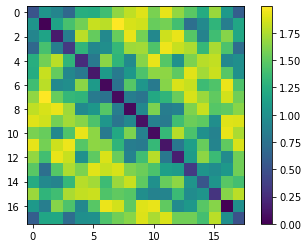

In [21]:
plt.imshow(similarity)
plt.colorbar()
plt.show()

We see that the mean similarity matrix has entries concentrated close to zero on the diagonal, and pushed away from zero on the off-diagonal. Thus, on the average, similarity scores tend to be close to zero when the matrices are similar, and away from zero when they are dissimilar, as expected.